In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

train_data = torchvision.datasets.CIFAR10(root='./data', 
                                          train=True,
                                          download=True,
                                          transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data',
                                         train=False,
                                         download=True,
                                         transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
loaders = {
    'train': torch.utils.data.DataLoader(train_data,
                                         batch_size=4,
                                         shuffle=True,
                                         num_workers=2),
    
    'test': torch.utils.data.DataLoader(test_data,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2),
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

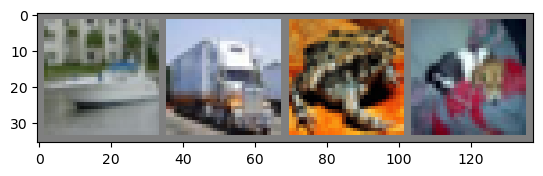

ship truck frog dog


In [5]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(loaders['train'])
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x), 2))
        x = self.pool(F.relu(self.conv2(x), 2))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(5):
    total_loss = 0.0

    for i, data in enumerate(loaders['train'], 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()

        total_loss += l.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, total_loss / 2000))
            total_loss = 0.0
end.record()

torch.cuda.synchronize()
print("Finished Training")
print(start.elapsed_time(end))

[1,  2000] loss: 1.081
[1,  4000] loss: 1.118
[1,  6000] loss: 1.079
[1,  8000] loss: 1.088
[1, 10000] loss: 1.075
[1, 12000] loss: 1.093
[2,  2000] loss: 1.018
[2,  4000] loss: 1.018
[2,  6000] loss: 1.053
[2,  8000] loss: 1.034
[2, 10000] loss: 1.037
[2, 12000] loss: 1.029
[3,  2000] loss: 0.989
[3,  4000] loss: 0.979
[3,  6000] loss: 0.993
[3,  8000] loss: 1.001
[3, 10000] loss: 1.008
[3, 12000] loss: 1.010
[4,  2000] loss: 0.921
[4,  4000] loss: 0.958
[4,  6000] loss: 0.943
[4,  8000] loss: 0.986
[4, 10000] loss: 0.985
[4, 12000] loss: 0.983
[5,  2000] loss: 0.896
[5,  4000] loss: 0.922
[5,  6000] loss: 0.913
[5,  8000] loss: 0.953
[5, 10000] loss: 0.948
[5, 12000] loss: 0.960
Finished Training
241717.8125


In [13]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


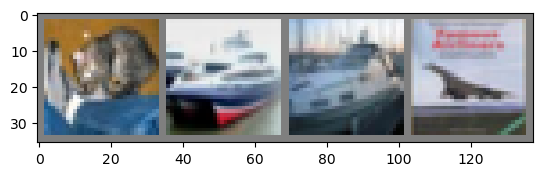

GroundTruth:  cat ship ship plane


In [14]:
dataiter = iter(loaders['test'])
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [15]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat ship ship ship


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 63 %


In [30]:
from PIL import Image

img = transform(Image.open("img.jpg"))

with torch.no_grad():
    output = model(img)

predicted_class = torch.argmax(output).item()
print(classes[predicted_class])

plane
